<a href="https://colab.research.google.com/github/uzFer/APS360-Project/blob/main/APS360_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
from scipy import ndimage
import os
import cv2

In [3]:
def rgb2gray(img):
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

def gradient_x(img):
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    return grad_img / np.max(grad_img)

def gradient_y(img):
    grad_img = ndimage.convolve(img, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
    return grad_img/np.max(grad_img)

def gradient_mag(fx, fy):
    grad_mag = np.hypot(fx, fy)
    return grad_mag / np.max(grad_mag)

In [4]:
def closest_dir_function(grad_dir):
    closest_dir_arr = np.zeros(grad_dir.shape)

    for i in range(1, int(grad_dir.shape[0] - 1)):
        for j in range(1, int(grad_dir.shape[1] - 1)):
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)):
                closest_dir_arr[i, j] = 0
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)):
                closest_dir_arr[i, j] = 45
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)):
                closest_dir_arr[i, j] = 90
            else:
                closest_dir_arr[i, j] = 135

    return closest_dir_arr

In [5]:
def non_maximal_suppressor(grad_mag, closest_dir):
    thinned_output = np.zeros(grad_mag.shape)

    for i in range(1, int(grad_mag.shape[0] - 1)):
        for j in range(1, int(grad_mag.shape[1] - 1)):
            if(closest_dir[i, j] == 0):
                if((grad_mag[i, j] > grad_mag[i, j + 1]) and (grad_mag[i, j] > grad_mag[i, j - 1])):
                    thinned_output[i, j] = grad_mag[i, j]
                else:
                    thinned_output[i, j] = 0

            elif(closest_dir[i, j] == 45):
                if((grad_mag[i, j] > grad_mag[i + 1, j + 1]) and (grad_mag[i, j] > grad_mag[i - 1, j - 1])):
                    thinned_output[i, j] = grad_mag[i, j]
                else:
                    thinned_output[i, j] = 0

            elif(closest_dir[i, j] == 90):
                if((grad_mag[i, j] > grad_mag[i + 1, j]) and (grad_mag[i, j] > grad_mag[i - 1, j])):
                    thinned_output[i, j] = grad_mag[i, j]
                else:
                    thinned_output[i, j] = 0

            else:
                if((grad_mag[i, j] > grad_mag[i + 1, j - 1]) and (grad_mag[i, j] > grad_mag[i - 1, j + 1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else:
                    thinned_output[i, j] = 0

    return thinned_output/np.max(thinned_output)

In [6]:
def DFS(img):
    for i in range(1, int(img.shape[0] - 1)):
        for j in range(1, int(img.shape[1] - 1)):
            if(img[i, j] == 1):
                t_max = max(img[i - 1, j - 1], img[i - 1, j], img[i - 1, j + 1], img[i, j - 1],
                            img[i, j + 1], img[i + 1, j - 1], img[i + 1, j], img[i + 1, j + 1])
                if(t_max == 2):
                    img[i, j] = 2


def hysteresis_thresholding(img):
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff

    temp_img = np.copy(img)

    for i in range(1, int(img.shape[0] - 1)):
        for j in range(1, int(img.shape[1] - 1)):
            if(img[i, j] > t_high):
                temp_img[i, j] = 2
            elif(img[i, j] < t_low):
                temp_img[i, j] = 0
            else:
                temp_img[i, j] = 1

    total_strong = np.sum(temp_img == 2)

    while(1):
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)):
            break
        total_strong = np.sum(temp_img == 2)

    for i in range(1, int(temp_img.shape[0] - 1)):
        for j in range(1, int(temp_img.shape[1] - 1)):
            if(temp_img[i, j] == 1):
                temp_img[i, j] = 0

    temp_img = temp_img / np.max(temp_img)
    return temp_img

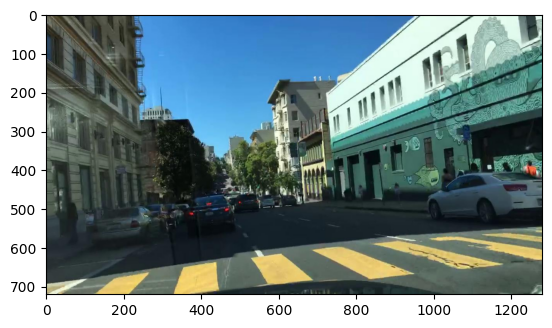

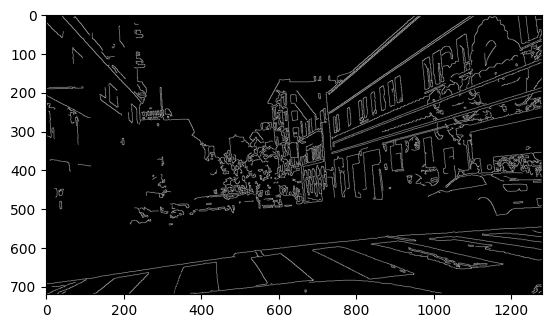

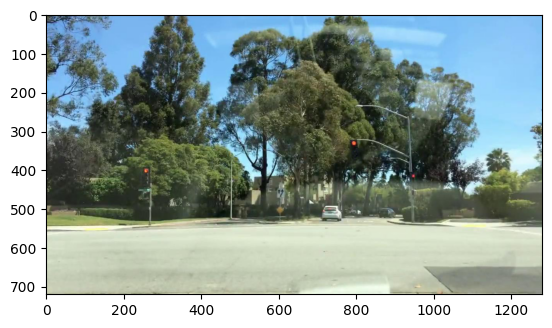

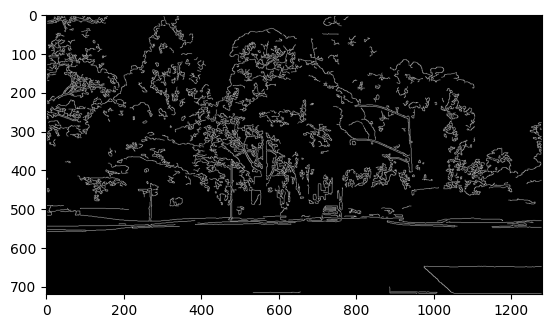

In [28]:
from PIL import Image

output_path = "/content/drive/MyDrive/test_output/"
folder_path = "/content/drive/MyDrive/test/"
img_names = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img in img_names:
    input_img = imageio.imread(folder_path + img)
    plt.imshow(input_img)
    plt.show()

    gray_input_img = rgb2gray(input_img)
    blur_img = ndimage.gaussian_filter(gray_input_img, sigma = 1.0)

    x_grad = gradient_x(blur_img)
    y_grad = gradient_y(blur_img)

    grad_mag = gradient_mag(x_grad, y_grad)
    grad_mag_pil = Image.fromarray(np.uint8(grad_mag))

    grad_dir = np.degrees(np.arctan2(y_grad, x_grad))
    grad_dir_pil = Image.fromarray(np.uint8(grad_dir))

    closest_dir = closest_dir_function(grad_dir)
    thinned_output = non_maximal_suppressor(grad_mag, closest_dir)
    thinned_output_pil = Image.fromarray(np.uint8(thinned_output))

    output_img = hysteresis_thresholding(thinned_output)
    plt.imshow(output_img, cmap = plt.get_cmap('gray'))
    plt.show()
    final_output_pil = Image.fromarray(np.uint8(output_img))
    cv2.imwrite(output_path + "/" + img.split(".")[0] + "_final_output.jpg", (output_img * 255).astype(np.uint8))